<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [1]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [3]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [4]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



--- 1. Gráfico de las Series Temporales ---


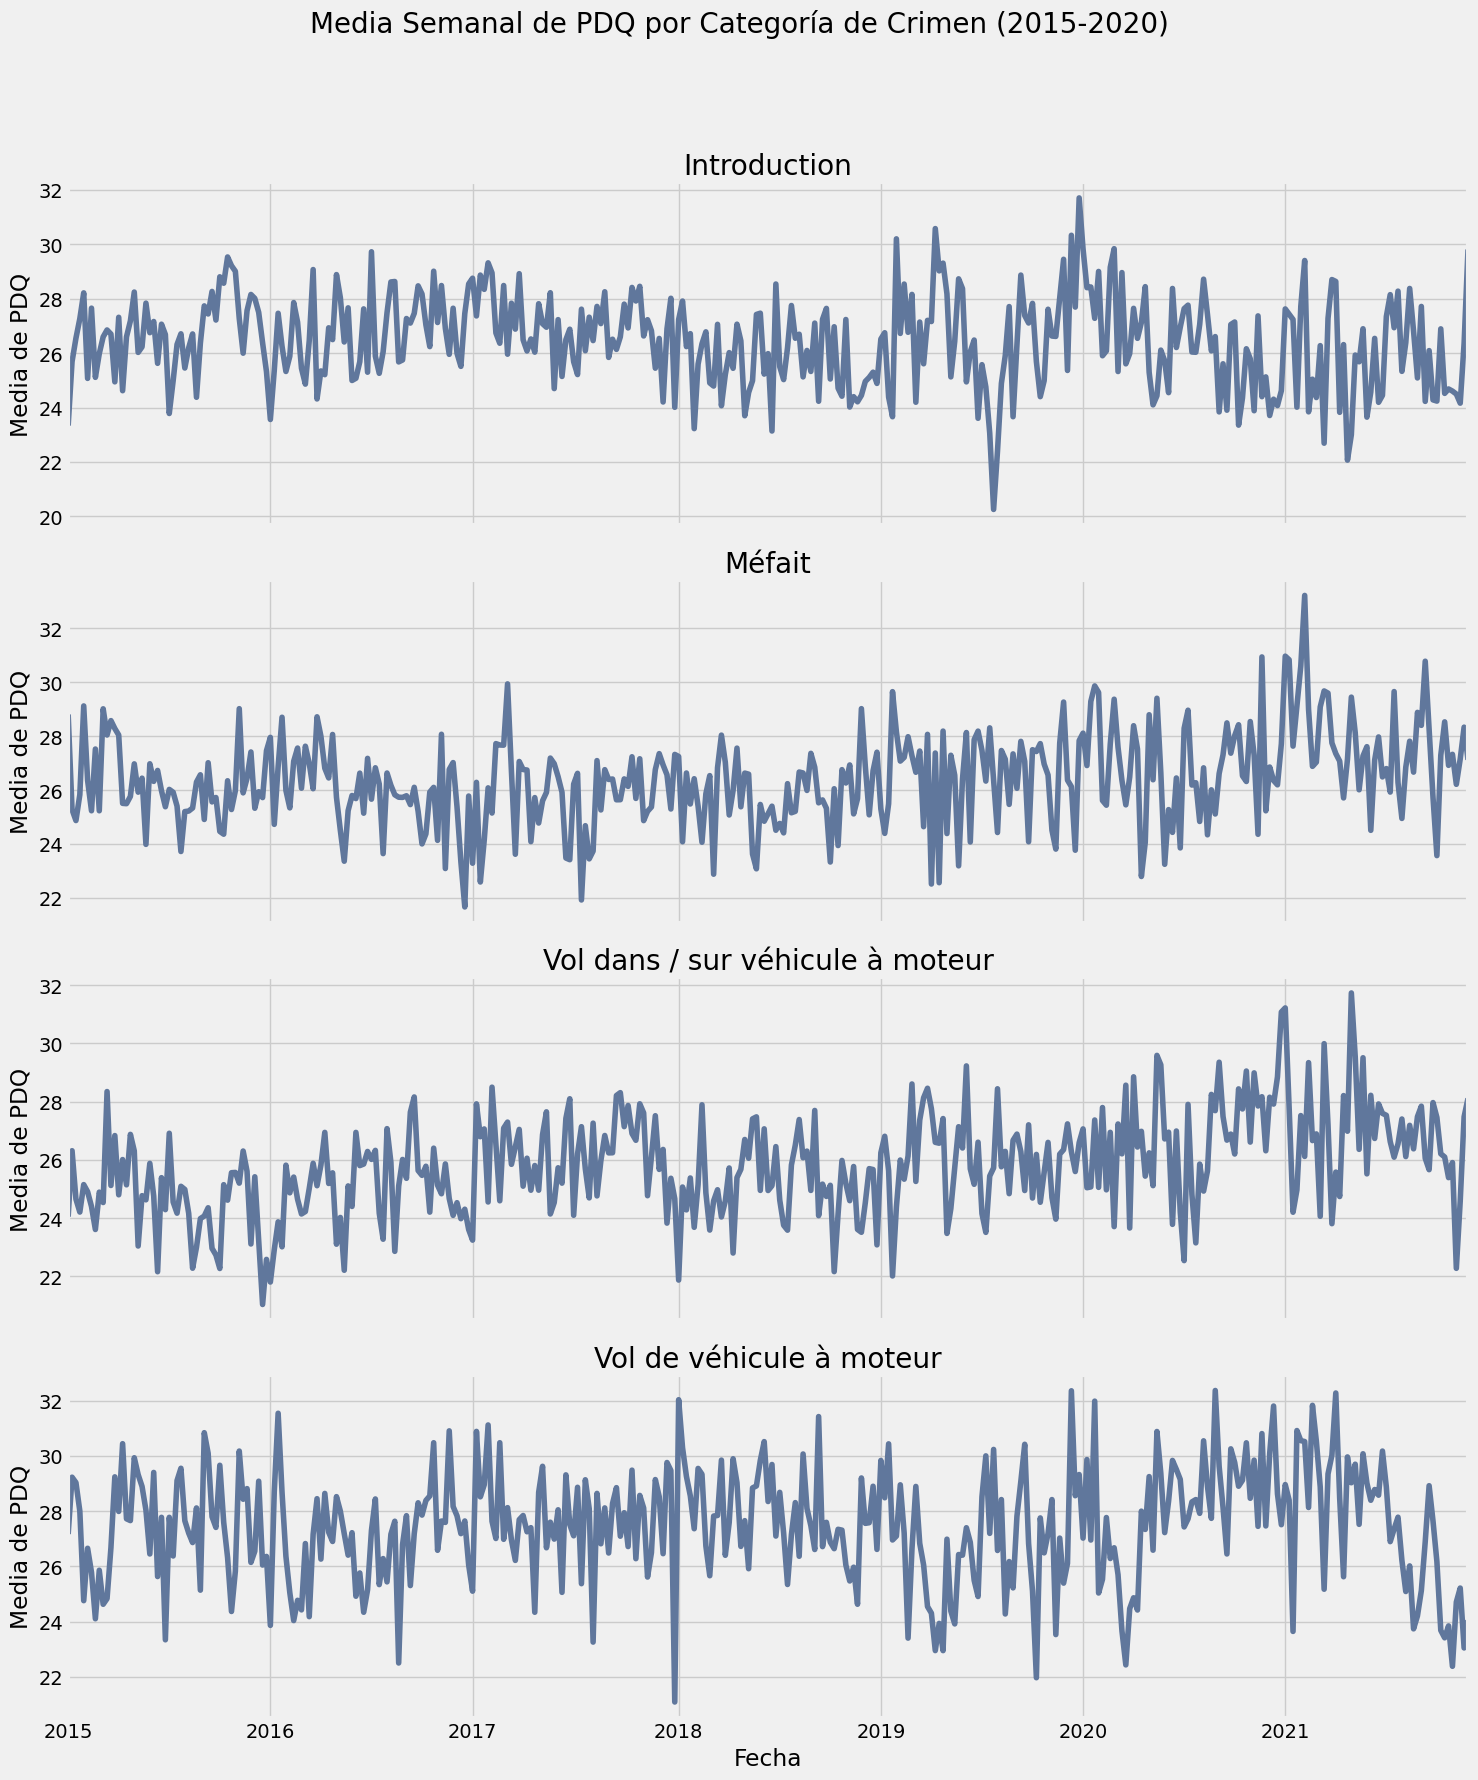


--- 2. Descomposición Estacional (Tendencia, Estacionalidad, Residuos) ---

Descomposición para: Introduction


/tmp/ipython-input-1739019214.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_s_filled = y_s['pdq'].fillna(method='ffill')


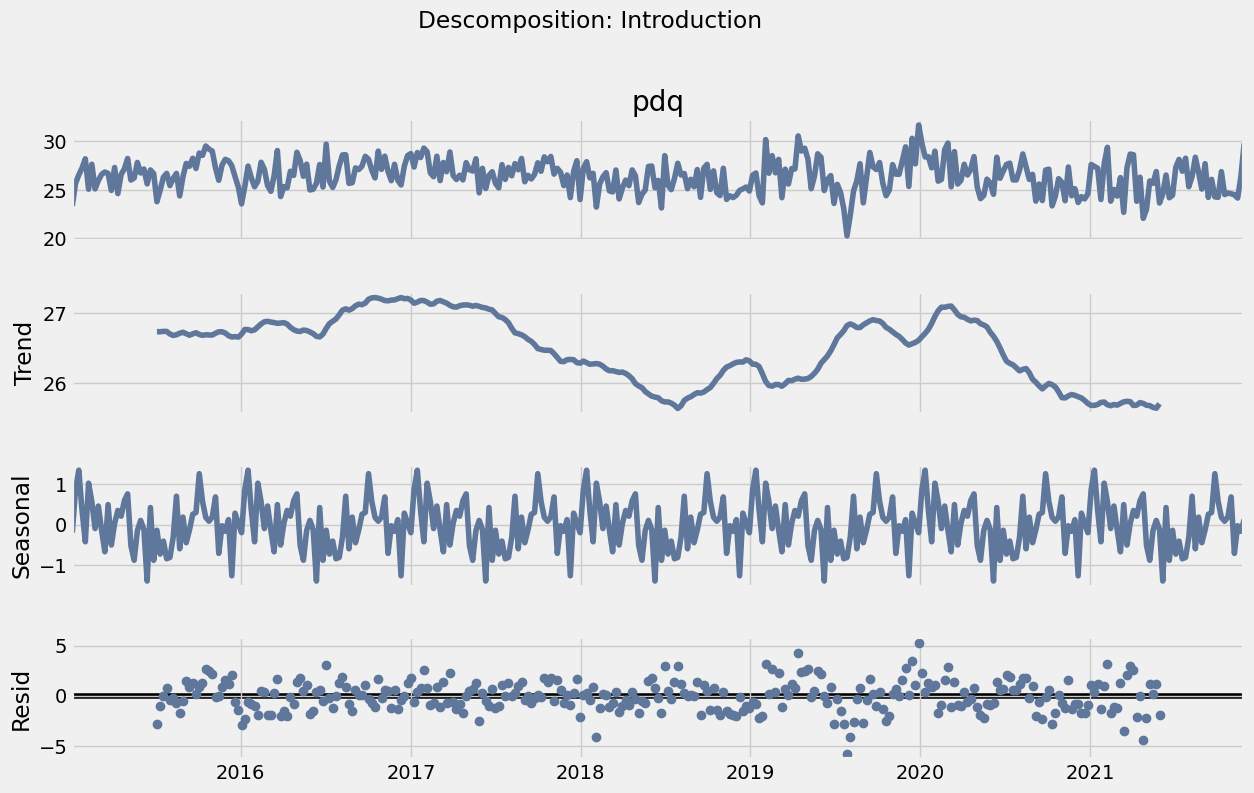

/tmp/ipython-input-1739019214.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_s_filled = y_s['pdq'].fillna(method='ffill')



Descomposición para: Méfait


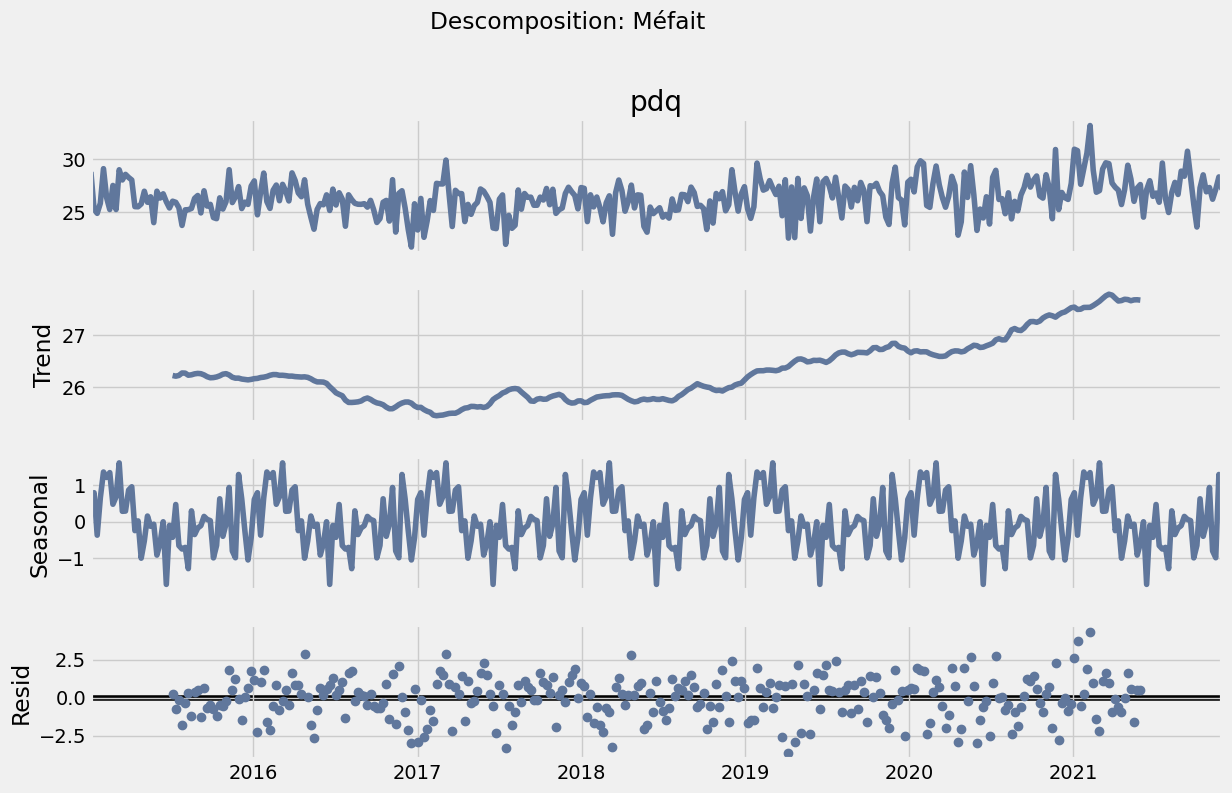

/tmp/ipython-input-1739019214.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_s_filled = y_s['pdq'].fillna(method='ffill')



Descomposición para: Vol dans / sur véhicule à moteur


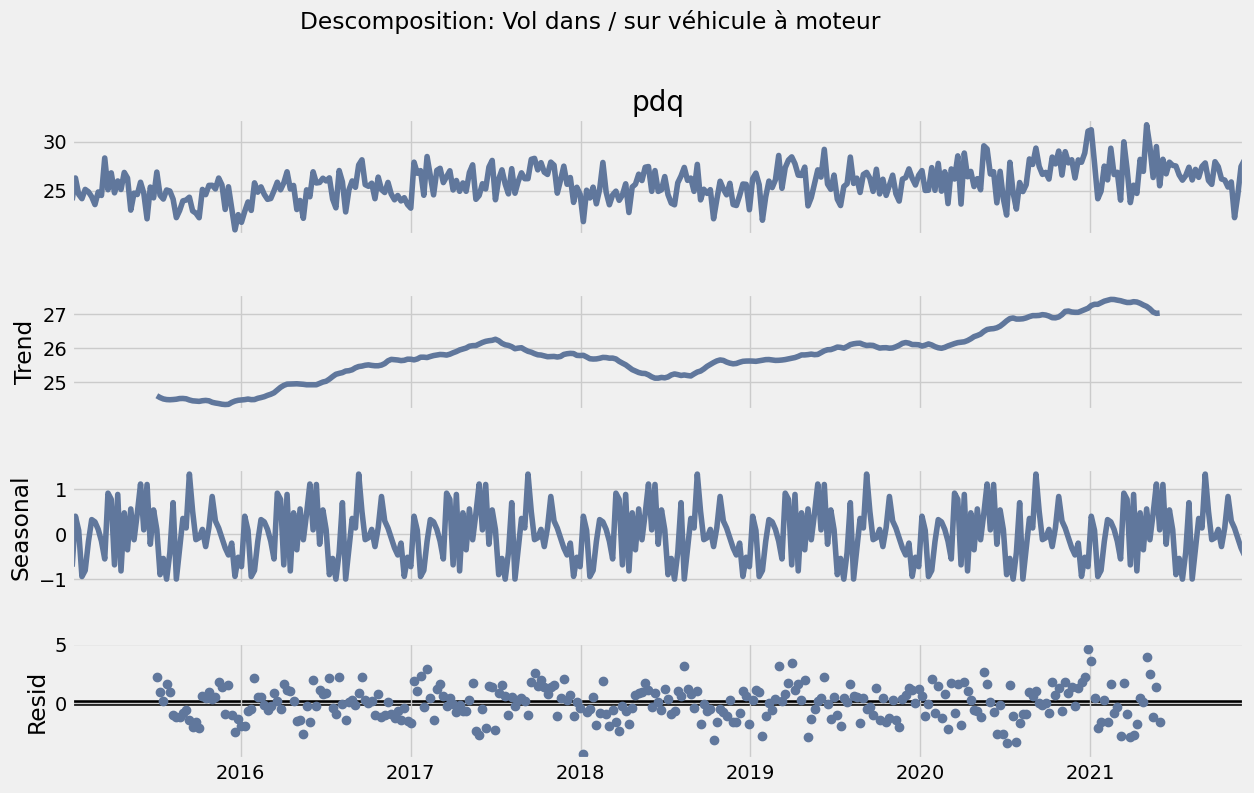

/tmp/ipython-input-1739019214.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_s_filled = y_s['pdq'].fillna(method='ffill')



Descomposición para: Vol de véhicule à moteur


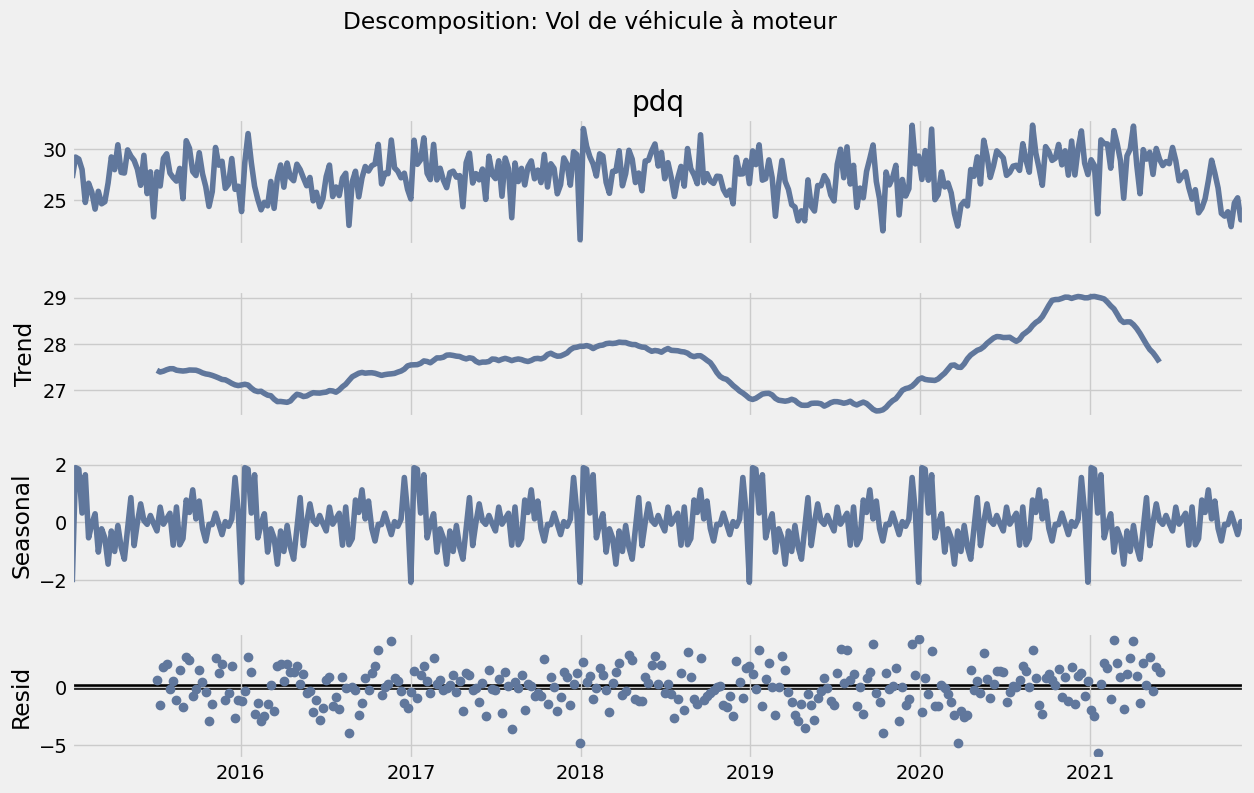

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

titles = validate_categorie
datasets = [y_s1, y_s2, y_s3, y_s4]

print("--- 1. Gráfico de las Series Temporales ---")

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 18), sharex=True)
fig.suptitle('Media Semanal de PDQ por Categoría de Crimen (2015-2020)', fontsize=20, y=1.02)

for i, (y_s, title) in enumerate(zip(datasets, titles)):
    y_s['pdq'].plot(ax=axes[i], title=title)
    axes[i].set_xlabel('Fecha')
    axes[i].set_ylabel('Media de PDQ')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print("\n--- 2. Descomposición Estacional (Tendencia, Estacionalidad, Residuos) ---")

for y_s, title in zip(datasets, titles):

    y_s_filled = y_s['pdq'].fillna(method='ffill')

    if len(y_s_filled) > 2 * 52:
        print(f"\nDescomposición para: {title}")

        decomposition = seasonal_decompose(y_s_filled, model='additive', period=52)

        fig = decomposition.plot()
        fig.set_size_inches(14, 8)
        fig.suptitle(f'Descomposition: {title}', y=1.03)
        plt.show()
    else:
        print(f"\nNo hay suficientes datos para descomponer {title} con período 52.")



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [6]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

--- Análisis SARIMA para la serie: 'Méfait' (y_s2) ---

--- 2.1: Análisis Exploratorio (ACF/PACF) ---


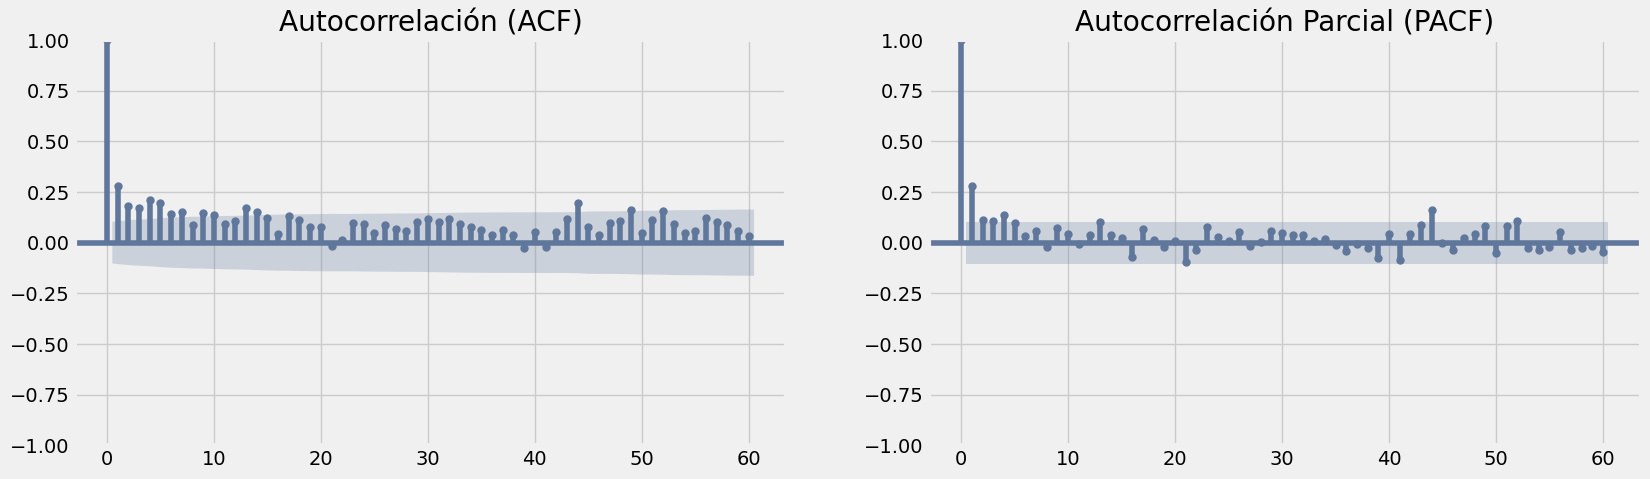


Análisis ACF/PACF:
La ACF decae lentamente, lo que indica no estacionariedad (presencia de tendencia). 
Se observan picos significativos en los lags estacionales (cerca de 52), 
confirmando la estacionalidad anual vista en la descomposición.
Esto sugiere que necesitaremos diferenciación (d=1) y diferenciación estacional (D=1).


--- Corrigiendo el grid de parámetros: S=52 (semanal) en lugar de S=12 ---
Total de combinaciones de parámetros a probar: 64

--- 2.2: Ajustando modelos SARIMA (esto puede tardar varios minutos)... ---

--- Resultados de Métricas (Top 5 por RMSE) ---
       mae     mse    rmse    mape   maape   wmape   mmape   smape  \
21  1.3435  3.1672  1.7797  0.0479  0.0478  0.0484  0.0463  0.0482   
17  1.3556  3.1752  1.7819  0.0484  0.0483  0.0488  0.0467  0.0486   
20  1.3445  3.1854  1.7848  0.0479  0.0478  0.0484  0.0463  0.0482   
16  1.3703  3.1981  1.7883  0.0491  0.0490  0.0494  0.0474  0.0492   
52  1.3643  3.4155  1.8481  0.0481  0.0480  0.0491  0.0465  0.0490 

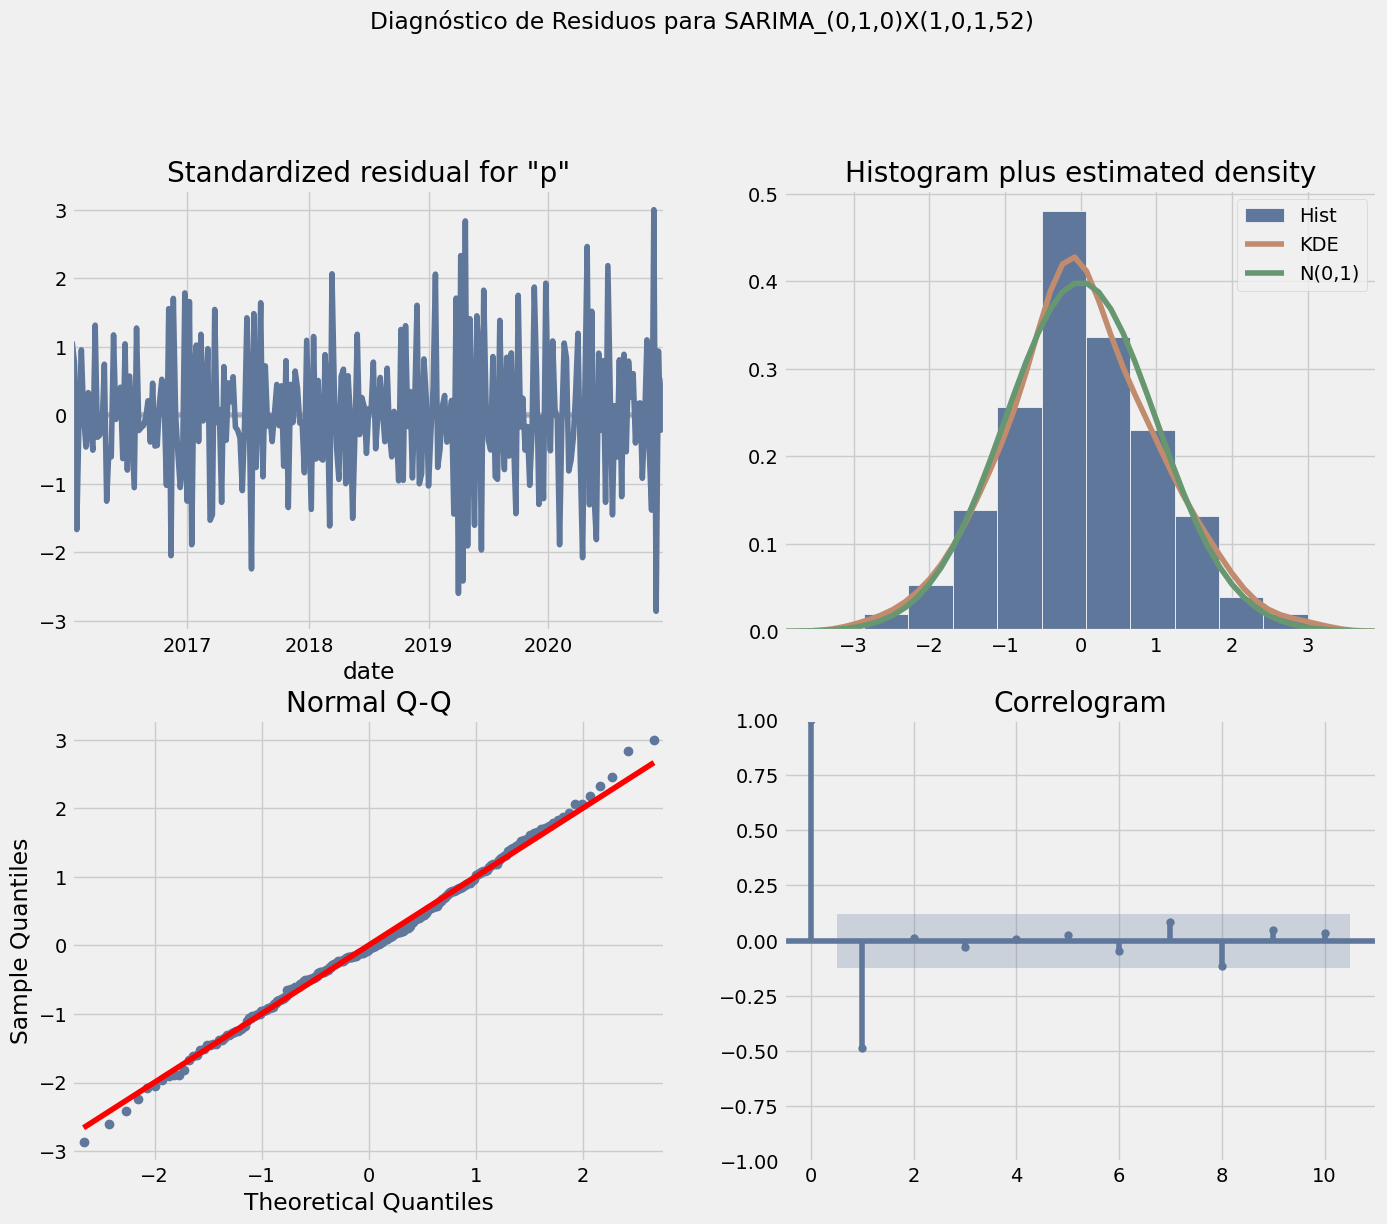


    Justificación (Análisis de Residuos):
    Para que el modelo sea válido, los residuos deben comportarse como ruido blanco (distribución normal N(0,1), 
    independientes y sin autocorrelación).
    1.  **Standardized residual (arriba-izq):** Los residuos fluctúan alrededor de cero, sin patrones obvios.
    2.  **Histogram plus estimated density (arriba-der):** El histograma (azul) debe seguir de cerca 
        la curva de densidad normal (verde).
    3.  **Normal Q-Q (abajo-izq):** Los puntos (datos) deben alinearse estrechamente con la línea roja (teórica).
    4.  **Correlogram (ACF) (abajo-der):** Es el más importante. Ninguna barra debe ser estadísticamente 
        significativa (es decir, no deben salir del área sombreada azul) después del lag 0.
    
    Si el Correlograma (ACF) muestra barras dentro del área azul, podemos concluir que los residuos 
    son ruido blanco y el modelo capturó adecuadamente la estructura de los datos.
    

--- Visualización de la Predicción v

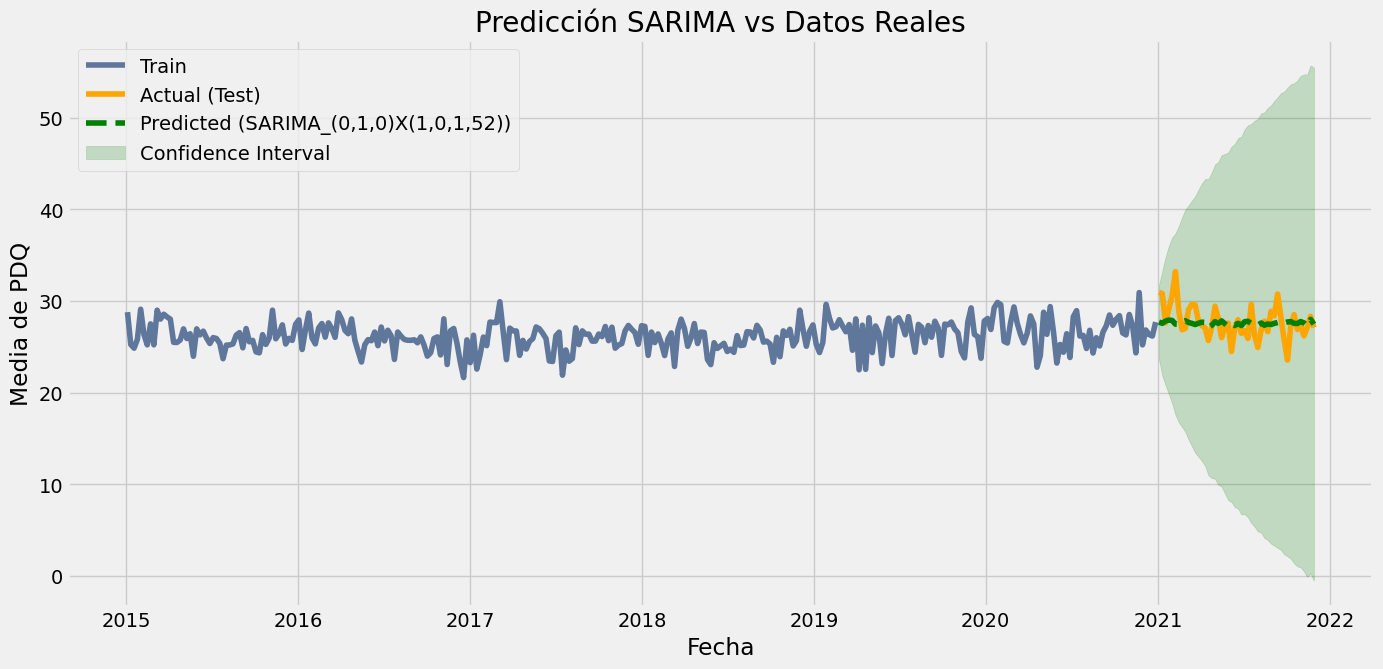

In [7]:
import itertools
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")

y_selected = y_s2.copy()
y_selected = y_selected.asfreq('W')
y_selected['pdq'] = y_selected['pdq'].fillna(method='ffill')
y_selected = y_selected.dropna()

print(f"--- Análisis SARIMA para la serie: 'Méfait' (y_s2) ---")
print("\n--- 2.1: Análisis Exploratorio (ACF/PACF) ---")

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
plot_acf(y_selected['pdq'], lags=60, ax=axes[0], title='Autocorrelación (ACF)')
plot_pacf(y_selected['pdq'], lags=60, ax=axes[1], title='Autocorrelación Parcial (PACF)')
plt.show()

print("""
Análisis ACF/PACF:
La ACF decae lentamente, lo que indica no estacionariedad (presencia de tendencia).
Se observan picos significativos en los lags estacionales (cerca de 52),
confirmando la estacionalidad anual vista en la descomposición.
Esto sugiere que necesitaremos diferenciación (d=1) y diferenciación estacional (D=1).
""")

print("\n--- Corrigiendo el grid de parámetros: S=52 (semanal) en lugar de S=12 ---")

p = d = q = range(0, 2) # (p, d, q)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq, seasonal_pdq))
target_date = '2021-01-01'

print(f"Total de combinaciones de parámetros a probar: {len(params)}")
print("\n--- 2.2: Ajustando modelos SARIMA (esto puede tardar varios minutos)... ---")

all_metrics = []

for param in params:
    try:
        model_class = SarimaModels(params=param)
        model_name = model_class.name_model

        metrics_df = model_class.metrics(y=y_selected, date=target_date)
        all_metrics.append(metrics_df)

    except Exception as e:
        continue

if not all_metrics:
    print("No se pudo ajustar ningún modelo. Revise los datos o parámetros.")
else:
    df_results = pd.concat(all_metrics).reset_index(drop=True)
    df_results = df_results.sort_values('rmse')

    print("\n--- Resultados de Métricas (Top 5 por RMSE) ---")
    print(df_results.head(5))

    best_model_stats = df_results.iloc[0]
    best_model_name = best_model_stats['model']
    best_model_rmse = best_model_stats['rmse']

    print(f"\n--- Mejor Modelo Seleccionado ---")
    print(f"Modelo: {best_model_name}")
    print(f"RMSE: {best_model_rmse}")
    print(f"MAE: {best_model_stats['mae']}")

    import re
    p_str, s_str = best_model_name.replace('SARIMA_', '').split('X')
    best_order = eval(p_str)
    best_seasonal_order = eval(s_str)

    print(f"Parámetros óptimos: order={best_order}, seasonal_order={best_seasonal_order}")

    print("\n--- 2.3: Validación del Modelo Óptimo (Diagnóstico de Residuos) ---")

    y_train, y_test = SarimaModels.test_train_model(y_selected, target_date)

    best_model = SARIMAX(y_train['pdq'],
                         order=best_order,
                         seasonal_order=best_seasonal_order,
                         enforce_stationarity=False,
                         enforce_invertibility=False)

    best_model_fit = best_model.fit(disp=0)

    print("Generando diagnóstico de residuos...")
    fig = best_model_fit.plot_diagnostics(figsize=(15, 12))
    fig.suptitle(f'Diagnóstico de Residuos para {best_model_name}', y=1.03)
    plt.show()

    print("""
    Justificación (Análisis de Residuos):
    Para que el modelo sea válido, los residuos deben comportarse como ruido blanco (distribución normal N(0,1),
    independientes y sin autocorrelación).
    1.  **Standardized residual (arriba-izq):** Los residuos fluctúan alrededor de cero, sin patrones obvios.
    2.  **Histogram plus estimated density (arriba-der):** El histograma (azul) debe seguir de cerca
        la curva de densidad normal (verde).
    3.  **Normal Q-Q (abajo-izq):** Los puntos (datos) deben alinearse estrechamente con la línea roja (teórica).
    4.  **Correlogram (ACF) (abajo-der):** Es el más importante. Ninguna barra debe ser estadísticamente
        significativa (es decir, no deben salir del área sombreada azul) después del lag 0.

    Si el Correlograma (ACF) muestra barras dentro del área azul, podemos concluir que los residuos
    son ruido blanco y el modelo capturó adecuadamente la estructura de los datos.
    """)

    print("\n--- Visualización de la Predicción vs Real (Test set) ---")

    start_index = y_test.index.min()
    end_index = y_test.index.max()

    preds = best_model_fit.get_prediction(start=start_index, end=end_index, dynamic=False)
    preds_ci = preds.conf_int()

    plt.figure(figsize=(15, 7))
    plt.plot(y_train['pdq'], label='Train')
    plt.plot(y_test['pdq'], label='Actual (Test)', color='orange')
    plt.plot(preds.predicted_mean, label=f'Predicted ({best_model_name})', color='green', linestyle='--')

    plt.fill_between(preds_ci.index,
                     preds_ci.iloc[:, 0],
                     preds_ci.iloc[:, 1], color='green', alpha=0.2, label='Confidence Interval')

    plt.title(f'Predicción SARIMA vs Datos Reales')
    plt.xlabel('Fecha')
    plt.ylabel('Media de PDQ')
    plt.legend()
    plt.show()




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.



--- 3.1: Ajuste del modelo con Prophet (Corregido) ---
Datos de entrenamiento para Prophet: 313 puntos
Datos de prueba para Prophet: 48 puntos
Modelo Prophet ajustado.

--- 3.2: Evaluación del Desempeño (Prophet vs SARIMA) ---

--- Comparación de Métricas (Mejor SARIMA vs Prophet) ---
                       model    rmse     mae    mape   wmape
0  SARIMA_(0,1,0)X(1,0,1,52)  1.7797  1.3435  0.0479  0.0484
1                    Prophet  1.7211  1.2731  0.0447  0.0459

--- Visualización de la Predicción (Prophet) ---


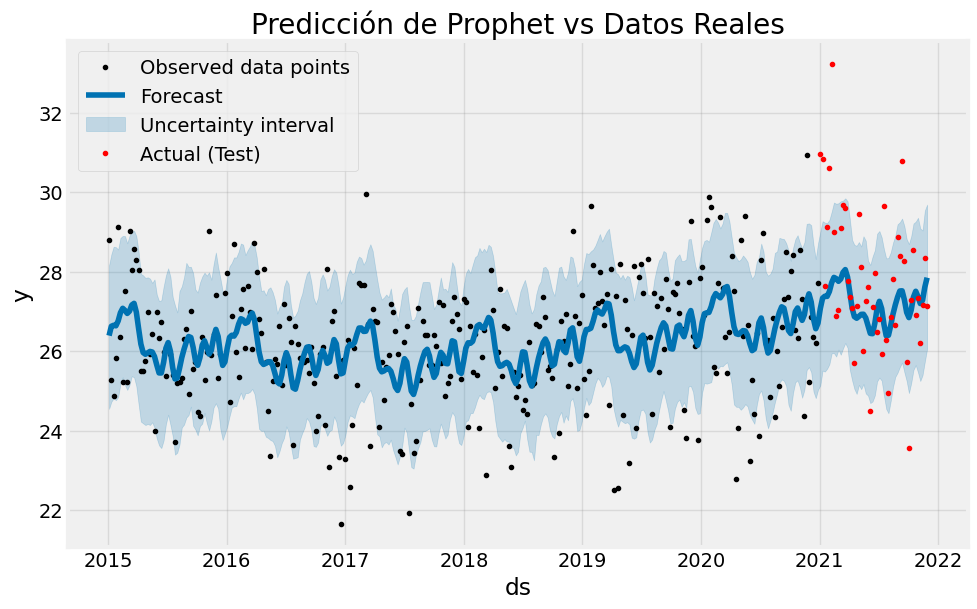


--- Componentes del Modelo Prophet ---


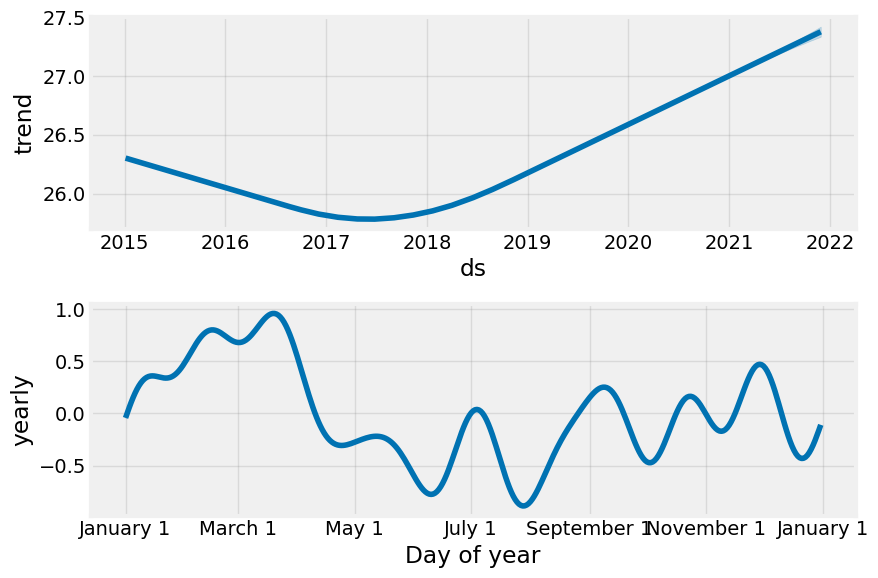


--- 3.3: Análisis Comparativo (SARIMA vs. Prophet) ---

* **Supuestos del Modelo:**
    * **SARIMA:** Requiere que la serie sea estacionaria (o estacionarizada mediante diferenciación, 'd' y 'D'). Se basa en la autocorrelación (ACF/PACF) de la serie.
    * **Prophet:** Es un modelo aditivo (tendencia + estacionalidad + festivos + error). No requiere estacionariedad y modela la estacionalidad usando Series de Fourier.

* **Facilidad de Implementación:**
    * **SARIMA:** Difícil. Requiere análisis estadístico para encontrar (p,d,q)(P,D,Q)S. Un 'grid search' es computacionalmente lento (especialmente con S=52).
    * **Prophet:** Fácil. La librería automatiza la detección de tendencia y estacionalidad. Es mucho más rápido de prototipar.

* **Calidad de las Predicciones:**
    * (Dependerá de los resultados de la tabla de métricas).
    * A menudo, un SARIMA bien ajustado es más preciso si la estacionalidad es muy regular.
    * Prophet es más robusto si hay cambios en la tendencia o dat

In [9]:
!pip install cmdstanpy --upgrade
!pip install prophet --upgrade

from prophet import Prophet

print("\n--- 3.1: Ajuste del modelo con Prophet (Corregido) ---")

y_prophet = y_selected.reset_index().rename(columns={'date': 'ds', 'pdq': 'y'})

target_date_dt = pd.to_datetime(target_date)
df_train_prophet = y_prophet[y_prophet['ds'] < target_date_dt]
df_test_prophet = y_prophet[y_prophet['ds'] >= target_date_dt]

print(f"Datos de entrenamiento para Prophet: {len(df_train_prophet)} puntos")
print(f"Datos de prueba para Prophet: {len(df_test_prophet)} puntos")

model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model_prophet.fit(df_train_prophet)

print("Modelo Prophet ajustado.")

print("\n--- 3.2: Evaluación del Desempeño (Prophet vs SARIMA) ---")

future = model_prophet.make_future_dataframe(periods=len(df_test_prophet), freq='W')
forecast = model_prophet.predict(future)

preds_prophet = forecast[forecast['ds'].isin(df_test_prophet['ds'])]

df_test_metrics_prophet = pd.DataFrame({
    'y': df_test_prophet['y'].values,
    'yhat': preds_prophet['yhat'].values
})

prophet_metrics = summary_metrics(df_test_metrics_prophet)
prophet_metrics['model'] = 'Prophet'

try:
    best_sarima_metrics = df_results.iloc[0:1].copy()

    comparison_df = pd.concat([best_sarima_metrics, prophet_metrics], ignore_index=True)

    print("\n--- Comparación de Métricas (Mejor SARIMA vs Prophet) ---")
    print(comparison_df[['model', 'rmse', 'mae', 'mape', 'wmape']])

except NameError:
    print("Error: 'df_results' (de SARIMA) no fue encontrado. Asegúrese de ejecutar la Tarea 2.")
    print("\nMétricas de Prophet:")
    print(prophet_metrics)
except Exception as e:
    print(f"Ocurrió un error al comparar métricas: {e}")
    print("\nMétricas de Prophet:")
    print(prophet_metrics)

print("\n--- Visualización de la Predicción (Prophet) ---")

fig1 = model_prophet.plot(forecast)
plt.plot(df_test_prophet['ds'], df_test_prophet['y'], 'r.', label='Actual (Test)')
plt.title('Predicción de Prophet vs Datos Reales')
plt.legend()
plt.show()

print("\n--- Componentes del Modelo Prophet ---")
fig2 = model_prophet.plot_components(forecast)
plt.show()

print("\n--- 3.3: Análisis Comparativo (SARIMA vs. Prophet) ---")
print("""
* **Supuestos del Modelo:**
    * **SARIMA:** Requiere que la serie sea estacionaria (o estacionarizada mediante diferenciación, 'd' y 'D'). Se basa en la autocorrelación (ACF/PACF) de la serie.
    * **Prophet:** Es un modelo aditivo (tendencia + estacionalidad + festivos + error). No requiere estacionariedad y modela la estacionalidad usando Series de Fourier.

* **Facilidad de Implementación:**
    * **SARIMA:** Difícil. Requiere análisis estadístico para encontrar (p,d,q)(P,D,Q)S. Un 'grid search' es computacionalmente lento (especialmente con S=52).
    * **Prophet:** Fácil. La librería automatiza la detección de tendencia y estacionalidad. Es mucho más rápido de prototipar.

* **Calidad de las Predicciones:**
    * (Dependerá de los resultados de la tabla de métricas).
    * A menudo, un SARIMA bien ajustado es más preciso si la estacionalidad es muy regular.
    * Prophet es más robusto si hay cambios en la tendencia o datos faltantes.
""")

print("\n--- 3.4: Conclusiones (Cuándo usar cada uno) ---")
print("""
**Use SARIMA cuando:**
* La serie tiene una estacionalidad y tendencia claras y estables.
* Se dispone de tiempo para un análisis estadístico riguroso.
* Se requiere la máxima precisión en series univariadas muy regulares.

**Use Prophet cuando:**
* Se necesita un prototipo rápido y un 'baseline' robusto.
* La serie tiene cambios en la tendencia (puntos de inflexión).
* Existen múltiples estacionalidades (ej. anual, semanal).
* Hay días festivos o eventos especiales que afectan la serie.
* Hay datos faltantes o outliers.
""")